In [1]:
import pandas as pd
import numpy as np
import os
import string
import math
from time import localtime, strftime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import decomposition
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def write_csv(ID, Price, filename=""):
    result = pd.DataFrame(columns = ["Id", "SalePrice"])
    result["Id"] = ID
    result["SalePrice"] = Price
    if filename == "":
        filename = "Result_" + strftime("%Y%m%d%H%M", localtime())
    filename = filename + ".csv"
    result.to_csv(os.path.join("./Result/", filename), sep=",", index=False)
    return result

def plot_scatter(x, y, c=3):
    number_feature = []
    for fea, typ in zip(data.columns, data.dtypes):
        if typ == "int64" or typ == "float64":
            number_feature.append(fea)
    nrows = len(number_feature) // c
    ncols = c
    for i, fea in enumerate(number_feature):
        plt.subplot(nrows, ncols, i+1)
        plt.scatter(x[fea], y)
        plt.title(fea)
    plt.show()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

data_dir = "./Data/"

train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))
train_Y = train['SalePrice']
train = train.drop(["Id", "SalePrice"], axis=1)
test_id = test["Id"]
test = test.drop(["Id"], axis=1)
data = pd.concat([train, test])

train_num = train.shape[0]
test_num = test.shape[0]
print(data.shape)
print(data.describe())
print(data.isna().sum().sort_values(ascending=False))
print(train.dtypes)

(2919, 79)
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  2919.000000  2433.000000    2919.000000  2919.000000  2919.000000   
mean     57.137718    69.305795   10168.114080     6.089072     5.564577   
std      42.517628    23.344905    7886.996359     1.409947     1.113131   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    59.000000    7478.000000     5.000000     5.000000   
50%      50.000000    68.000000    9453.000000     6.000000     5.000000   
75%      70.000000    80.000000   11570.000000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  2919.000000   2919.000000  2896.000000  2918.000000  2918.000000   
mean   1971.312778   1984.264474   102.201312   441.423235    49.582248   
std      30.291442     20.894344   179.334253   455.610826   169.205611   
min 

In [4]:
number_feature = []
object_feature = []
for fea, typ in zip(data.columns, data.dtypes):
    if typ == "int64" or typ == "float64":
        number_feature.append(fea)
    if typ == "object":
        object_feature.append(fea)
print("Number_Feature:%i, Object_Feature:%i" %(len(number_feature), len(object_feature)))
print(number_feature)
data.info()

Number_Feature:36, Object_Feature:43
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig      

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


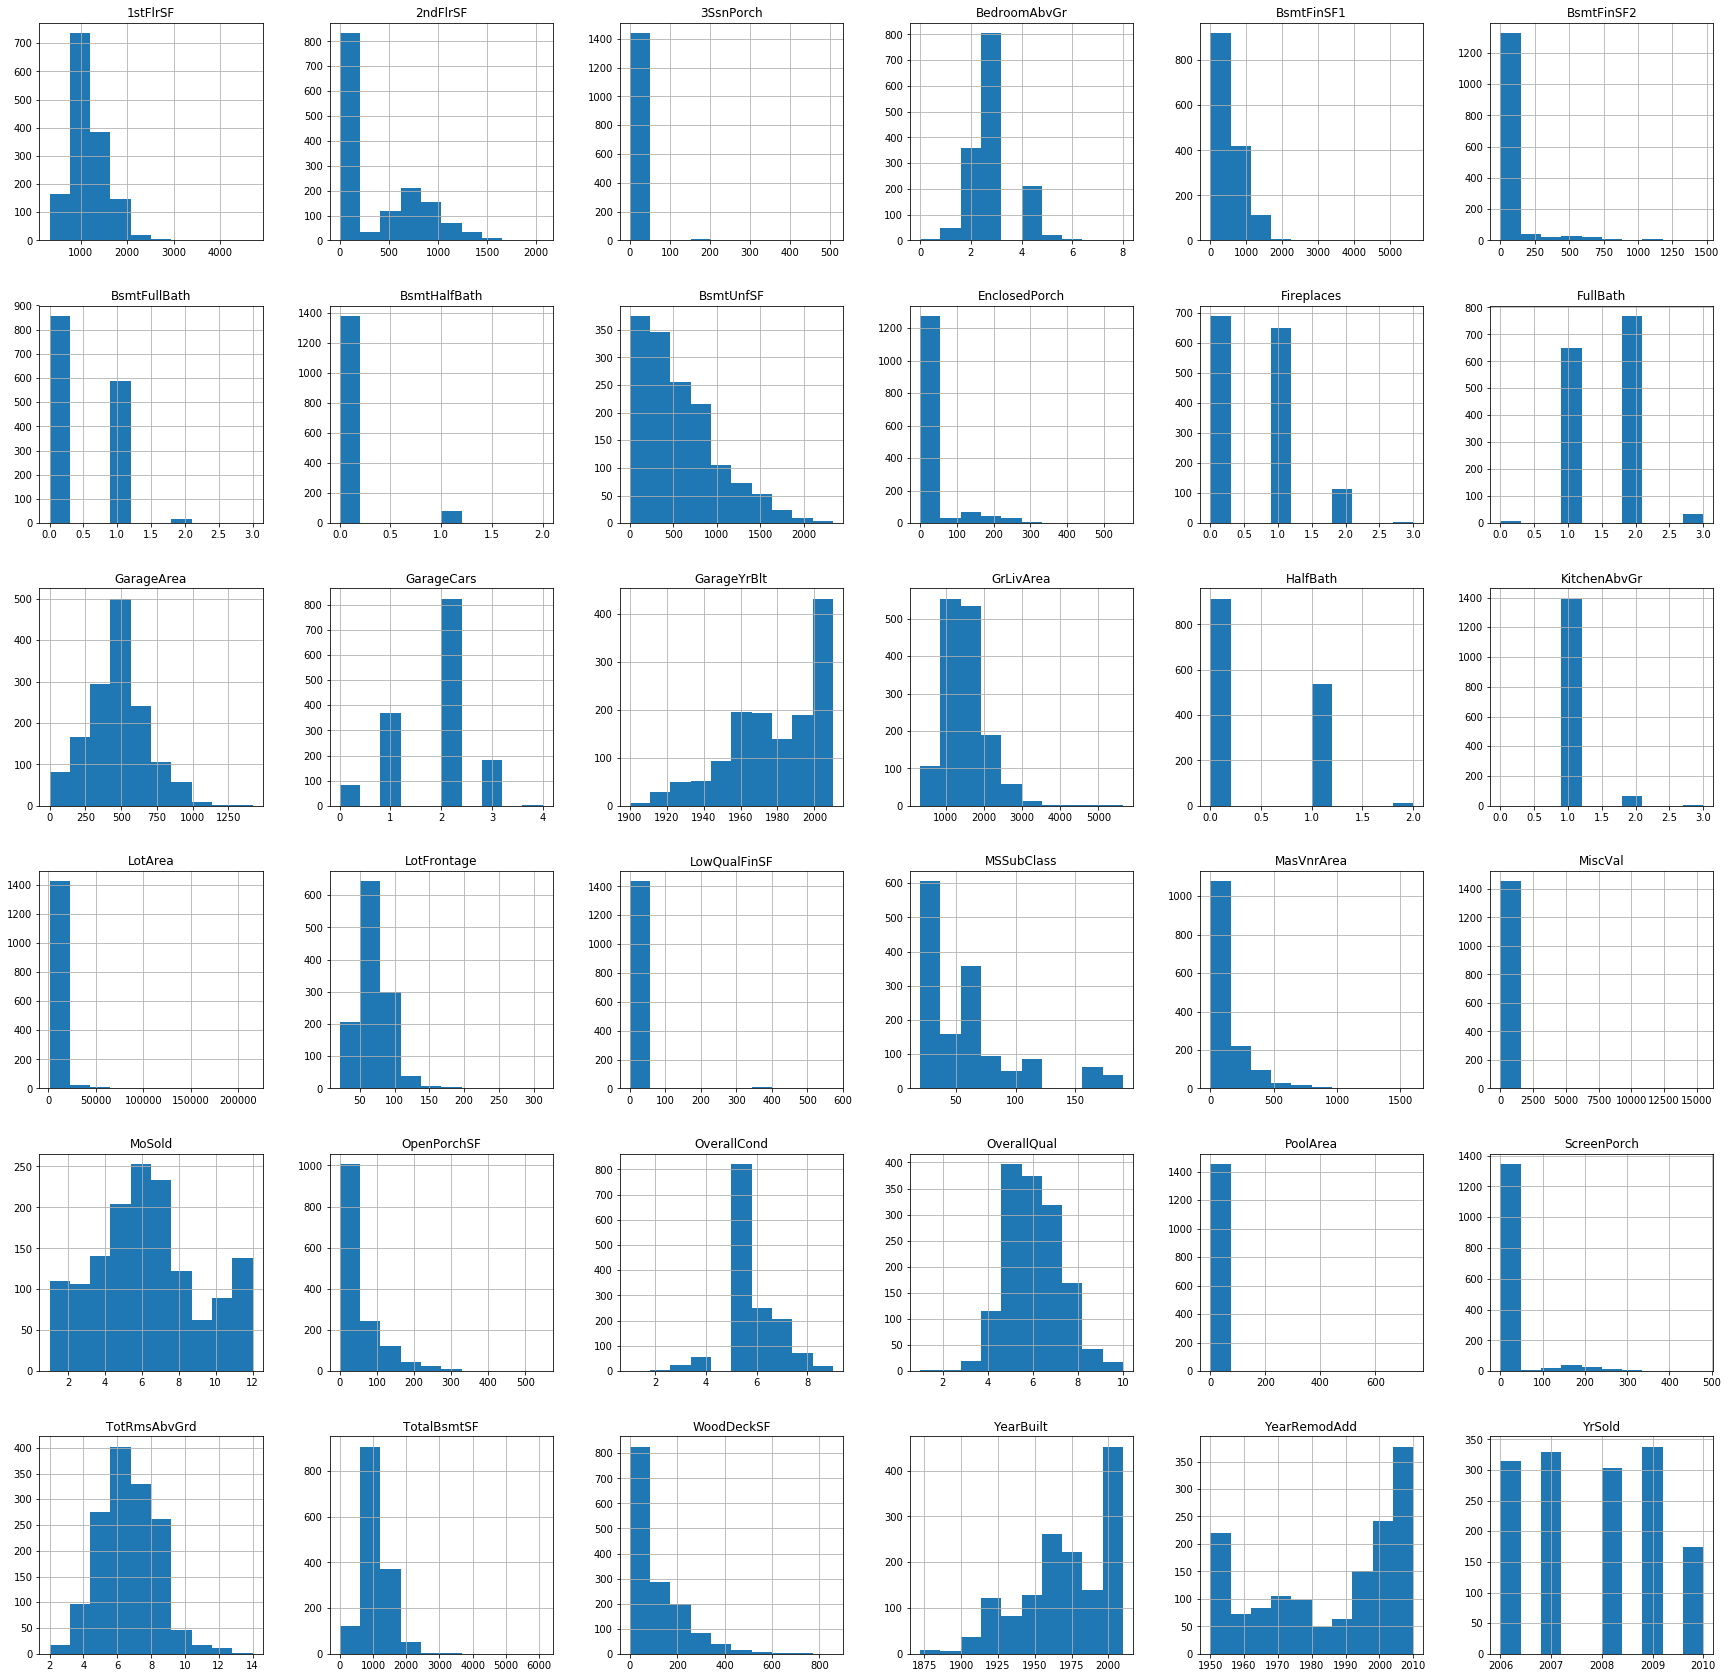

In [5]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
train.hist(ax = ax)
plt.show()

# 缺失值填補

In [6]:
def Missing_Replace(data, fea_array, replace="None"):
    for fea in fea_array:
        if replace == "Mean":
            data[fea] = data[fea].fillna(data[fea].mean())
        elif replace == "Mode":
            data[fea] = data[fea].fillna(str(data[fea].mode()[0]))
        else:
            data[fea] = data[fea].fillna(replace)
    return data

Missing_None = ["MasVnrType", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageCond", "GarageQual", "PoolQC", "Fence", "MiscFeature", "Alley", "Utilities"]
Missing_0 = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF",
             "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea", "GarageYrBlt"]
Missing_Mean = ["1stFlrSF"]
Missing_Mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Foundation", "BsmtExposure", "Electrical", 
                "KitchenQual", "Functional", "SaleType"]
data_dp = data.copy()
data_dp = Missing_Replace(data_dp, Missing_None, replace="None")
data_dp = Missing_Replace(data_dp, Missing_0, replace=0)
data_dp = Missing_Replace(data_dp, Missing_Mean, replace="Mean")
data_dp = Missing_Replace(data_dp, Missing_Mode, replace="Mode")
print(data_dp.isna().sum().sort_values(ascending=False).head(10))

SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
dtype: int64


In [7]:
#plt.figure(figsize=(30,30))
#plot_scatter(train, train_Y, 4)

# Feature Engineering

In [8]:
#去除偏態，把面積資料都取Log
LogTranf_columns = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", 
                    "LowQualFinSF", "GrLivArea", "GarageArea"]
for fea in LogTranf_columns:
    data_dp[fea] = np.log(data_dp[fea] + 1)

In [9]:
OneHot_columns = ["MSZoning"]
Label_columns = [x for x in object_feature if x not in OneHot_columns]
data_dp = pd.get_dummies(data_dp, columns=OneHot_columns)

for fea in Label_columns:
    data_dp[fea] = LabelEncoder().fit_transform(data_dp[fea])
print(data_dp.head(5))

   MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandContour  \
0          60         65.0     8450       1      1         3            3   
1          20         80.0     9600       1      1         3            3   
2          60         68.0    11250       1      1         0            3   
3          70         60.0     9550       1      1         0            3   
4          60         84.0    14260       1      1         0            3   

   Utilities  LotConfig  LandSlope  Neighborhood  Condition1  Condition2  \
0          0          4          0             5           2           2   
1          0          2          0            24           1           2   
2          0          4          0             5           2           2   
3          0          0          0             6           2           2   
4          0          2          0            15           2           2   

   BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0 

In [10]:
train_dp = data_dp.iloc[:train_num, :]
train_dp["SalePrice"] = train_Y
MeanGroup_columns = ["OverallQual"]
data_fe = data_dp.copy()
for fea in MeanGroup_columns:
    MeanGroup_data = train_dp.groupby("OverallQual")["SalePrice"].mean().reset_index()
    MeanGroup_data.columns = [fea, f"{fea}_Mean"]
    data_fe = pd.merge(data_fe, MeanGroup_data, on=fea, how='left')
    data_fe = data_fe.drop([fea], axis=1)
print(data_dp.shape)
print(data_fe.shape)

(2919, 83)
(2919, 83)


C:\Users\Hsin-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
pca = decomposition.PCA(n_components=50)
pca.fit(data_dp)
data_pca = pca.transform(data_dp)
data_pca = pd.DataFrame(data_pca)
print(data_pca.shape)
print(type(data_pca))
print(pca.explained_variance_ratio_) 
print(pca.explained_variance_)

(2919, 50)
<class 'pandas.core.frame.DataFrame'>
[9.90657883e-01 5.10497248e-03 3.21649192e-03 5.04650058e-04
 2.37720759e-04 7.35072238e-05 6.39374786e-05 4.91803154e-05
 2.90584936e-05 2.01512982e-05 1.49032715e-05 1.20504159e-05
 1.00431794e-05 3.37702853e-06 5.45984268e-07 3.18283184e-07
 2.08608575e-07 1.36935031e-07 1.17398075e-07 8.18389439e-08
 5.26149262e-08 4.52071050e-08 4.16418776e-08 3.96586936e-08
 3.63984690e-08 3.32215840e-08 2.91033191e-08 2.65521860e-08
 2.52720889e-08 2.39445578e-08 2.21483022e-08 2.02455294e-08
 1.93690773e-08 1.65341633e-08 1.58225834e-08 1.55290430e-08
 1.39730732e-08 1.38580185e-08 1.33179620e-08 1.22425601e-08
 1.14635931e-08 1.12811390e-08 1.01512482e-08 9.41396815e-09
 8.41478903e-09 8.15665321e-09 7.56135418e-09 7.17173352e-09
 6.39799188e-09 5.82783120e-09]
[6.22084241e+07 3.20567068e+05 2.01979813e+05 3.16895322e+04
 1.49276900e+04 4.61589075e+03 4.01495800e+03 3.08828100e+03
 1.82472993e+03 1.26540204e+03 9.35851873e+02 7.56706626e+02
 6.3

In [13]:
train_X = data_fe.iloc[:train_num,:]
test_x = data_fe.iloc[(train_num):,:]
#train_X = data_pca.iloc[:train_num,:]
#test_x = data_pca.iloc[(train_num):,:]
print(train_X.shape, print(train_num))
print(test_x.shape, print(test_num))

1460
(1460, 83) None
1459
(1459, 83) None


In [14]:
temp = train_X.copy()
temp["SalePrice"] = train_Y
temp_corr = temp.corr()

SalePrice           1.000000
OverallQual_Mean    0.827153
GrLivArea           0.695147
GarageCars          0.640409
ExterQual           0.636884
BsmtQual            0.593734
1stFlrSF            0.591299
KitchenQual         0.589189
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
YearRemodAdd        0.507101
MasVnrArea          0.472614
Fireplaces          0.466929
GarageFinish        0.425684
GarageType          0.415283
HeatingQC           0.400178
Foundation          0.382479
GarageArea          0.371597
TotalBsmtSF         0.325883
WoodDeckSF          0.324413
OpenPorchSF         0.315856
BsmtExposure        0.295407
MSZoning_RM         0.288065
HalfBath            0.284108
LotArea             0.263843
GarageYrBlt         0.261366
LotShape            0.255580
CentralAir          0.251328
GarageCond          0.246705
MSZoning_RL         0.245063
Electrical          0.234945
PavedDrive          0.231357
BsmtFullBath        0.227122
RoofStyle     

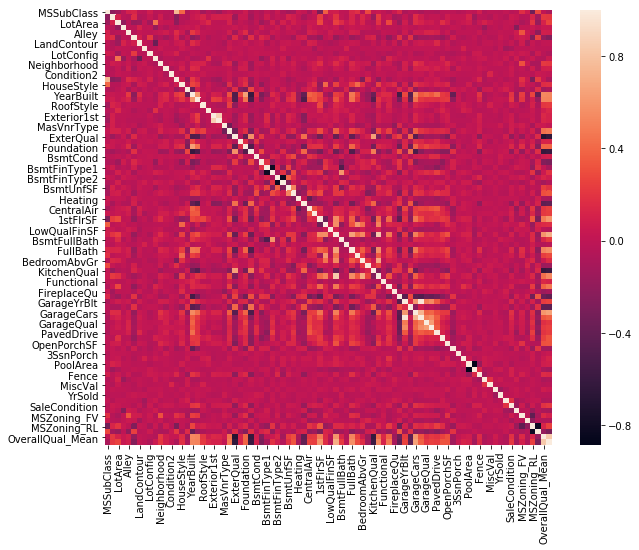

In [15]:
plt.figure(figsize = (10, 8))
print(abs(temp_corr["SalePrice"]).sort_values(ascending=False))
sns.heatmap(temp_corr)

In [16]:
train_Y = np.log1p(train_Y)


In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.1, random_state=727)

In [19]:
lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train)
rmse_train_reg = math.sqrt(mse(y_train, lr_reg.predict(x_train)))
rmse_valid_reg = math.sqrt(mse(y_valid, lr_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_reg)
print("Valid_RMSE: %.6f" %rmse_valid_reg)
y_pred_reg = lr_reg.predict(test_x)
#output = write_csv(test_ID, np.expm1(y_pred_reg), "reg_v3")

Train_RMSE: 0.122973
Valid_RMSE: 0.113721


In [21]:
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(x_train, y_train)
rmse_train_lasso = math.sqrt(mse(y_train, lasso_reg.predict(x_train)))
rmse_valid_lasso = math.sqrt(mse(y_valid, lasso_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_lasso)
print("Valid_RMSE: %.6f" %rmse_valid_lasso)
y_pred_lasso = lasso_reg.predict(test_x)
#output = write_csv(test_id, np.expm1(y_pred_lasso), "lasso_v3")

Train_RMSE: 0.208657
Valid_RMSE: 0.196653


In [26]:
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(x_train, y_train)
rmse_train_ridge = math.sqrt(mse(y_train, ridge_reg.predict(x_train)))
rmse_valid_ridge = math.sqrt(mse(y_valid, ridge_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_ridge)
print("Valid_RMSE: %.6f" %rmse_valid_ridge)
y_pred_ridge = ridge_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_ridge), "ridge_v3")

Train_RMSE: 0.123022
Valid_RMSE: 0.114247


In [23]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')
xg_reg.fit(x_train, y_train)
rmse_train_xg = math.sqrt(mse(y_train, xg_reg.predict(x_train)))
rmse_valid_xg = math.sqrt(mse(y_valid, xg_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_xg)
print("Valid_RMSE: %.6f" %rmse_valid_xg)
y_pred_xg = xg_reg.predict(test_x)
output = write_csv(test_id, np.expm1(y_pred_xg), "xgb_v3")

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:01:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train_RMSE: 0.087525
Valid_RMSE: 0.120531


In [25]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)
rmse_train_rf = math.sqrt(mse(y_train, rf_reg.predict(x_train)))
rmse_valid_rf = math.sqrt(mse(y_valid, rf_reg.predict(x_valid)))
print("Train_RMSE: %.6f" %rmse_train_rf)
print("Valid_RMSE: %.6f" %rmse_valid_rf)
y_pred_rf = rf_reg.predict(test_x)
#output = write_csv(test_ID, np.expm1(y_pred_rf), "rf_v1")

#rf_reg.importance

C:\Users\Hsin-PC\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train_RMSE: 0.067641
Valid_RMSE: 0.133937


In [17]:
print(rf_reg.feature_importances_)

[2.15514296e-03 1.93572677e-03 5.92899907e-03 1.71997074e-02
 1.08878263e-05 2.37725670e-04 1.43334161e-03 2.31950229e-03
 0.00000000e+00 1.64118771e-03 8.49369617e-04 7.58787239e-03
 1.27758866e-03 2.91987335e-06 2.87800083e-04 5.79098074e-04
 5.64344208e-01 2.41956462e-03 1.66905400e-02 7.31994931e-03
 9.11696529e-04 5.13040332e-07 1.88939608e-03 1.59255381e-03
 7.42406621e-04 4.95054681e-03 2.90824540e-04 2.70225035e-04
 5.09593773e-04 3.48503744e-03 2.39851215e-04 1.87602492e-03
 1.43545134e-03 4.58086509e-02 1.47977988e-03 3.80028362e-04
 7.10928050e-03 4.45913980e-02 3.26193481e-06 7.17830498e-04
 4.12679893e-03 1.41971312e-04 1.64712689e-02 2.05893059e-02
 4.68564318e-05 1.04798902e-01 7.95760329e-04 6.49013999e-05
 8.08879359e-04 3.43110552e-04 1.75121256e-03 3.47860354e-03
 2.65362463e-03 1.53002267e-02 4.25446181e-04 2.19706513e-03
 1.73140472e-03 5.01816875e-03 3.94911099e-03 1.22539154e-03
 3.06603272e-02 1.51616911e-02 2.03176946e-04 1.88394895e-04
 5.44956586e-04 3.438127

In [116]:
print(xgb.XGBRegressor.__doc__)

Implementation of the scikit-learn API for XGBoost regression.

    Parameters
    ----------
    max_depth : int
        Maximum tree depth for base learners.
    learning_rate : float
        Boosting learning rate (xgb's "eta")
    n_estimators : int
        Number of trees to fit.
    verbosity : int
        The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
    silent : boolean
        Whether to print messages while running boosting. Deprecated. Use verbosity instead.
    objective : string or callable
        Specify the learning task and the corresponding learning objective or
        a custom objective function to be used (see note below).
    booster: string
        Specify which booster to use: gbtree, gblinear or dart.
    nthread : int
        Number of parallel threads used to run xgboost.  (Deprecated, please use ``n_jobs``)
    n_jobs : int
        Number of parallel threads used to run xgboost.  (replaces ``nthread``)
    gamma : float
        Minimum lo